# Figure 4, Beta Factors and Cross Section

In [40]:
import pygmt
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  matplotlib import colors
import matplotlib.patches as mpatches
from pyproj import Transformer
import geopandas as gpd

In [41]:
cd

C:\Users\matthewt


In [42]:
cd Documents\Python_Scripts\GRL_2021_Figures

C:\Users\matthewt\Documents\Python_Scripts\GRL_2021_Figures


## Figure parameters

In [43]:
figheight=150 # in mm
#RIS extent
ris_xl=-700_000#-800_000
ris_yl=-1_500_000
ris_xh=450_000#500_000
ris_yh=-350_000

figwidth=figheight*(ris_xh-ris_xl)/(ris_yh-ris_yl) 
risratio = (ris_yh - ris_yl) / (figheight/1000)
risreg = str(ris_xl) + '/' + str(ris_xh) + '/' + str(ris_yl) + '/' + str(ris_yh) #W/E/S/N
risproj = "x1:" + str(risratio)
risproj_ll = "s0/-90/-71/1:" + str(risratio)

### Sample grids for x-section

In [44]:
a=(-590000,-1070000)
b=(-100000,-545000)
earth_profilelist=('tmp/BedMachine_surface_wgs_5k.nc',
             'tmp/BedMachine_icebase_wgs_5k.nc',
             'tmp/BedMachine_bed_wgs_5k.nc',
             'rosetta_lindeque_basement_g80kfilt.nc',
             '../Moho_Models/Moho_Shen_20k_pixel_wgs84.nc') # Shen et al. 2018, The Crust and Upper Mantle Structure ...
data_profilelist=('RIS_Grav_5k.nc',)
ice_vel='../PyGMT/Venturelli2020/antarctic_ice_vel_phase_map_v01-vmag.nc'
pygmt.makecpt(cmap = 'cool', series = '0/250/1', output = 'cpts/vel.cpt', continuous=True)
GHF='../GHF/Burton_2020_GHF_supp_data/Mean.tif'# Burton-Johnson et al. 2020, Geothermal heat flow in Antarctica; The Cryosphere

# Create profile coords, and sample value from gris in "earth_profilelist" as well as GHF and Ice Velocity
def create_profile(a, b):
    df = pd.DataFrame(data=np.linspace(start=a, stop=b, num=1000), columns=["x", "y"])
    return df
points = create_profile(a, b)
points['Distance'] = np.sqrt( (points.x-points.x.min())**2 + (points.y-points.y.min())**2 )
def sample_line(points, grid):
    points[grid] = (pygmt.grdtrack(points=points, grid=grid, newcolname=str(grid), verbose='e'))[grid]
    return points
# sample Earth Profiles
for i in earth_profilelist:
    earth_profiles=sample_line(points, i)
earth_profiles = sample_line(points, ice_vel)
earth_profiles = sample_line(points, GHF)
for y in list(range(len(earth_profilelist)))[1:]:  #fill NaN's in lower layer with upper layer
    earth_profiles[earth_profilelist[y]] = np.where(earth_profiles[earth_profilelist[y]].isnull(), earth_profiles[earth_profilelist[y-1]], earth_profiles[earth_profilelist[y]]) 
# sample Data Profiles
points = create_profile(a, b)
points['Distance'] = np.sqrt( (points.x-points.x.min())**2 + (points.y-points.y.min())**2 )
for i in data_profilelist:
    data_profiles=sample_line(points, i)
dist=data_profiles[['x','y','Distance']]
s=np.arange(min(dist.Distance), max(dist.Distance), 200000).tolist()
for i in s[1:]:
    dist.loc[dist.shape[0]] = [None, None, i]
dist.set_index('Distance', inplace=True)
dist=dist.sort_index().interpolate(method='index')
dist=dist.loc[dist.index.isin(s)]
earth_profiles[ice_vel].interpolate(method='linear', axis=0, inplace=True)

earth_profiles.set_index('Distance',inplace=True, drop=False)

Xresampled = np.arange(0,earth_profiles.Distance.max(),1000)

earth_profiles = earth_profiles.reindex(earth_profiles.index.union(Xresampled)).interpolate('values').loc[Xresampled]

## Plot grid and Xsection as subplots

gmtset [WARNING]: Representation of font type not recognized. Using default.
psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


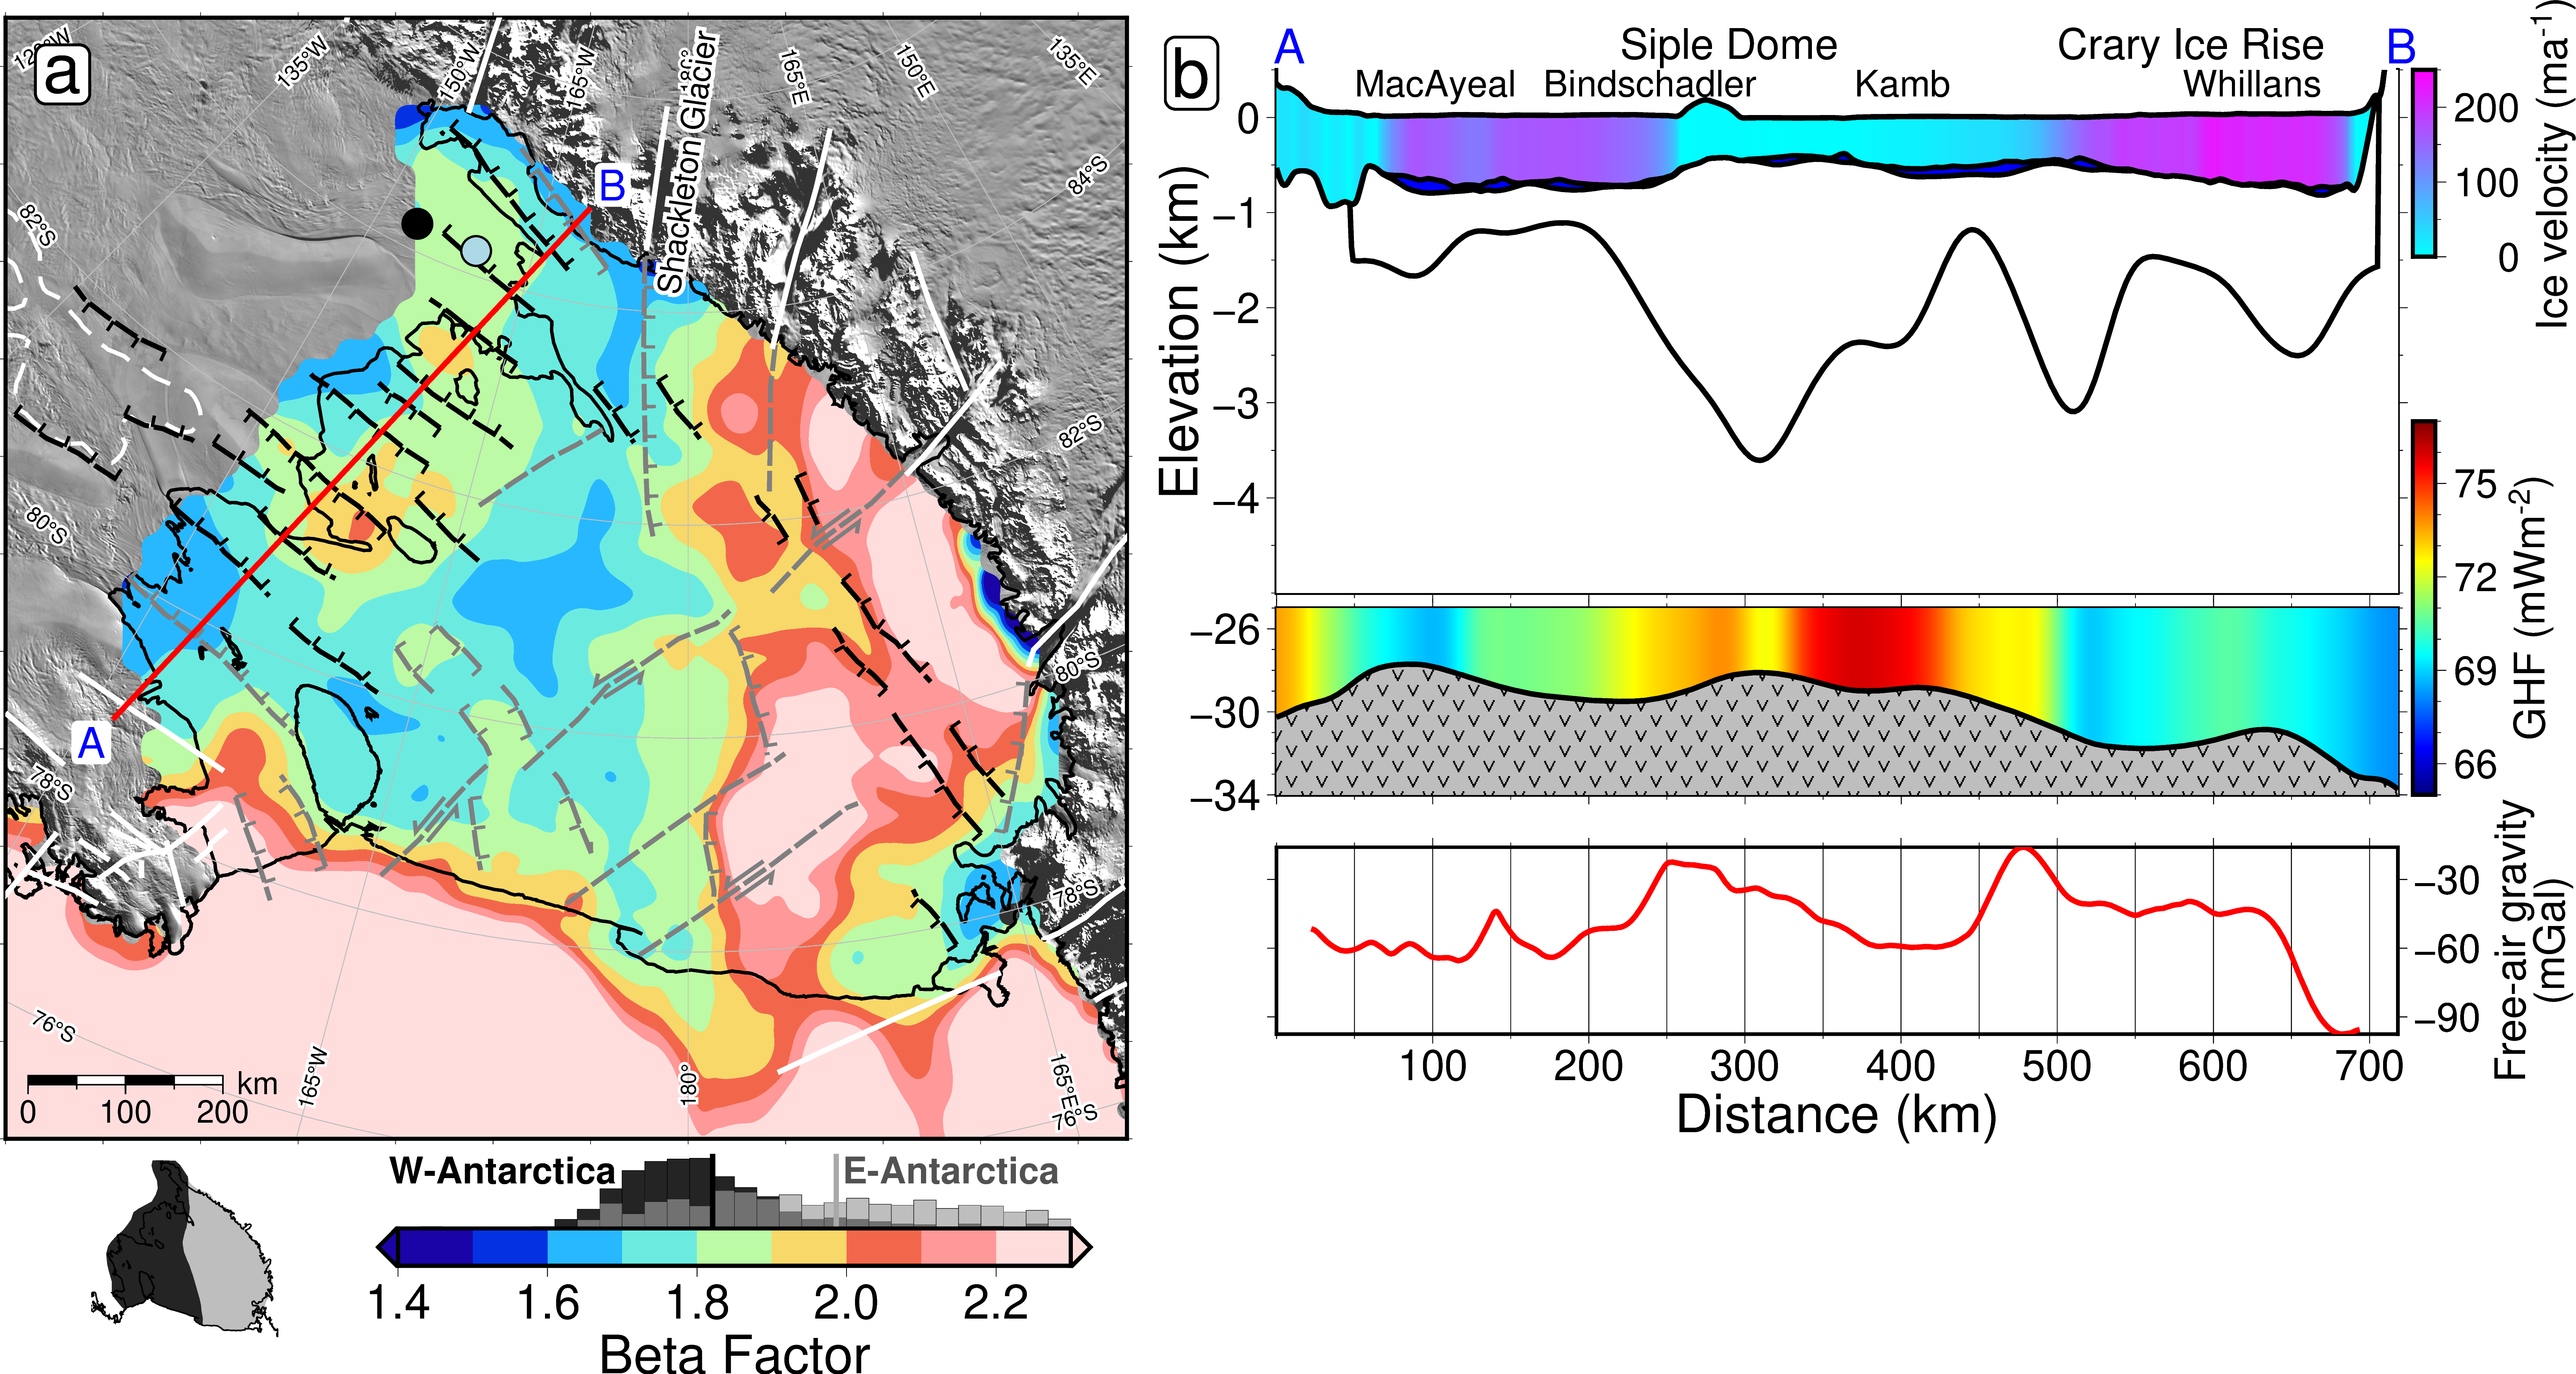

In [47]:
fig = pygmt.Figure()

fig.coast(region = risreg, projection = risproj_ll, land = 'white', water = 'white', frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')

fig.grdimage(region = risreg, projection = risproj, frame=["nwse", "xf100000", "yf100000", "g0"], 
             grid ='..\map_datasets\moa750_2009_hp1_v1.1.tif', 
             cmap = 'cpts/moa.cpt', transparency=20, dpi=500)
# Plot Beta Factors
beta_cpt_limits='1.4/2.3'
pygmt.makecpt(series = str(beta_cpt_limits)+'/.1', cmap = 'haxby', background='o', output='cpts/beta.cpt')

fig.grdimage(region=risreg, projection=risproj, transparency=0, grid ='../Beta_factors/An_beta_factor_RE.nc', cmap = 'cpts/beta.cpt', dpi=1000, nan_transparent=True)

# Plot the grounding/coast lines
fig.plot(data=gpd.read_file('..\RIS_basement_sediment\Data/Download/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('..\RIS_basement_sediment\Data/Download/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')

# Plot Bell et al. 2006 Basins
fig.plot(data = gpd.read_file('../shapefiles/bell_2006_outline.shp'), pen = 'thicker,white,-')

# Plot graticules overtop, at 2d latitude and 15d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black,-=2p,white', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = risproj_ll, region = risreg,
                frame = ["NSWE", "xa15g15", "ya2g2"],verbose='e')
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '8p,black',  
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90'):
    fig.basemap(projection = risproj_ll, region = risreg,
                frame = ["NSWE", "xa15g15", "ya2g2"],verbose='e')   

active_color='black'
inactive_color='gray50'
pen_fault='1.8p,'+str(inactive_color)+',10_2'#10:2 dash:gap
hatch_style='f+.4c/.3c+l+i'
# Plot christines inactive faults, with hatches
fig.plot(projection = risproj, data =gpd.read_file('../shapefiles/RIS_inactive_faults_normal.shp'), pen=pen_fault)
fig.plot(data =gpd.read_file('../shapefiles/RIS_inactive_faults_normal.shp'), pen='1.2p,'+str(inactive_color)+',10_2', style=hatch_style) #f for front, +.6c/0.3c for a tick every .6c, .3c long, +l for left side.
# Left lateral, with arrows
fig.plot(data =gpd.read_file('../shapefiles/RIS_inactive_faults_left_lateral.shp'), pen=pen_fault)
fig.plot(data =gpd.read_file('../shapefiles/RIS_inactive_faults_left_lateral.shp'), pen='1.5p,'+str(inactive_color), style='f-1c/.6c+l+s45+i') #f for front, -1 for 1 arrow, .8c for size of arrow, +l for left side, +s45 for arrow angle, +i for invisible line
# no kinematics
fig.plot(data =gpd.read_file('../shapefiles/RIS_inactive_faults.shp'), pen=pen_fault)
# Plot christines active faults, with hatches
fig.plot(data =gpd.read_file('../shapefiles/RIS_active_faults.shp'), pen='1.8p,'+str(active_color)+',10_2')
fig.plot(data =gpd.read_file('../shapefiles/RIS_active_faults.shp'), pen='1.2p,'+str(active_color)+',10_2', style=hatch_style) # f for front, +.3c/.3c for tick every .3c, .3c long, , +l for left side, +i for invisible

# Plot Goodge 2020 Faults, TAM
pen = '2p,white'
fig.plot(projection = risproj, data =gpd.read_file('../shapefiles/goodge_faults.shp'), pen=pen)
# Plot Siddoway et al. 2008 Faults, EVII
fig.plot(data =gpd.read_file('../shapefiles/siddoway_2008_EVII_faults.shp'), pen=pen) 
# Plot Ferraccioli et al. 2002 Faults, EVII
fig.plot(data =gpd.read_file('../shapefiles/ferraccioli_2002_faults.shp'), pen=pen)
# Plot Chiappini Ross Fault (Behrendt 1996)
fig.plot(data =gpd.read_file('../shapefiles/chiappini_2002_Ross_Fault.shp'), pen=pen)

#plot GHF points
RIS_GHF = pd.read_csv('../GHF/Burton_2020_GHF_points_RIS.csv')
RIS_GHF.loc[RIS_GHF.ID.str.contains('Lake Whillans'), ['ID']] ='SLW' # Change 'Lake Whillans' entries to "SLW"
RIS_GHF=RIS_GHF[RIS_GHF.ID.str.contains('SLW')].copy()#|WGZ
fig.plot(x=RIS_GHF.x, y=RIS_GHF.y,
         pen = '.8p,black',
         color = 'black',
         style = 'c0.4c', verbose='e')
#plot Whillans Basin Points
fig.plot(x=-217457, y=-589312,
         pen = '.8p,black',
         color = 'lightblue',
         style = 'c0.4c', verbose='e')

# for beta factor colorar with histogram and inset map
barwidth = figwidth/10 * 0.6 # color bar width is 40% of the map width, in cm
bar_offset= (figwidth/10 - (barwidth)/2)/2
pos_str = 'jBL+w' + str(barwidth) + 'c/.5c+jTL+o'+str(bar_offset)+'c/1.2c+h+ebf' 
hist_reg = str(beta_cpt_limits)+'/0/14',   # this needs to match CMAP limits, 0/14 of 0-14% for histogram
WANT_beta=pygmt.grd2xyz(grid='tmp/An_beta_factor_RIS_WANT_mask.nc')
EANT_beta=pygmt.grd2xyz(grid='tmp/An_beta_factor_RIS_EANT_mask.nc')
fig.shift_origin(xshift=str(bar_offset)+'c', yshift="-1.2c",)
fig.histogram( data=EANT_beta.z,
                region=hist_reg,
                fill='grey',
                projection="X"+str(barwidth)+"c/1c",
                frame=False,
                series=.03,#width of bin in data units
                pen=".1p",
                histtype=1,
                transparency=0) 
fig.histogram( data=WANT_beta.z,
                fill='gray14',
                frame=False,
                series=.03,
                pen=".1p",
                histtype=1,
                transparency=0) 
fig.histogram( data=EANT_beta.z,
                fill='grey',
                frame=False,
                series=.03,
                pen=".1p",
                histtype=1,
                transparency=50) 
fig.plot(x=[WANT_beta.z.mean(),WANT_beta.z.mean()], y=[0,14], pen='2p,black')
fig.plot(x=[EANT_beta.z.mean(),EANT_beta.z.mean()], y=[0,14], pen='2p,darkgray')
fig.text(x=1.54,y=11, text = "W-Antarctica",
        font = '14p,Helvetica-Bold,black', no_clip=True)
fig.text(x=2.14,y=11, text = "E-Antarctica",
        font = '14p,Helvetica-Bold,gray32') 
fig.shift_origin(xshift='-'+str(bar_offset)+'c', yshift="1.2c",)
with pygmt.config(FONT_ANNOT_PRIMARY = '18p,black', FONT_LABEL = '20p,black'):
    fig.colorbar(cmap='cpts/beta.cpt', position = pos_str, frame=['x.2+l"Beta Factor"'], verbose='e')
# INSET MAP
shelfwidth = 2.5 # width of inset in cm
shelfreg = '-690000/431000/-1390000/-374000'
shelfmap = 'X' + str(shelfwidth) + 'c'
with fig.inset(position='JTL+jCM+w'+str(shelfwidth)+'c+o2.4c/-2.4c'):
    fig.plot(projection = shelfmap, region = shelfreg, data=gpd.read_file('..\shapefiles\RIS_East.shp'), color = "gray")
    fig.plot(data=gpd.read_file('..\shapefiles\RIS_West.shp'), color = "gray14")
    fig.plot(data=gpd.read_file('..\shapefiles\MEaSUREs_groundingline.shp'), pen='0.5p,black')
    fig.plot(data=gpd.read_file('..\shapefiles\MEaSUREs_coastline.shp'), pen='0.5p,black') 
    
    
# Scalebar
with pygmt.config(FONT_ANNOT_PRIMARY = '12p,black', FONT_LABEL = '12p,black', MAP_SCALE_HEIGHT='7p', MAP_TICK_PEN_PRIMARY = '0.5p,black'):
    fig.basemap(region = risreg, projection = risproj_ll, map_scale='jBL+w200k+c170E/71S+f+l"km"+ar+o0.3c/0.6c', verbose='e') 
    
fig.text(projection = risproj, region = risreg,
        x = earth_profiles.x.iloc[0],
        y = earth_profiles.y.iloc[0], 
        text = "A", fill = 'white', font = '16p,Helvetica,blue', offset = 'j.1/.1',
        justify="TR", clearance = '+tO')

fig.text(x = earth_profiles.x.iloc[-1],
         y = earth_profiles.y.iloc[-1], 
         text = "B", fill = 'white', font = '16p,Helvetica,blue',  offset = 'j.1/.1',
         justify='BL', clearance = '+tO')

fig.text(position='TL', text = "a",  offset = 'j.5/.5', pen = '1p,black',
         fill = 'white', font = '26p,Helvetica,black', clearance = '+tO')
#y=-500000
fig.text(x=10000, y=-500000, angle=82, justify='BC', text='Shackleton Glacier', font='12,Helvetica,black,-=3p,white')
fig.text(x=10000, y=-500000, angle=82, justify='BC', text='Shackleton Glacier', font='12,Helvetica,black')
# plot profile line
fig.plot(projection=risproj, region=risreg, x=earth_profiles.x, y=earth_profiles.y, pen='2p,red')








fig.shift_origin(xshift=(figwidth/10)+.8, yshift=-.6)









region_lower=[earth_profiles.Distance.min(), earth_profiles.Distance.max(),
        -34000,
        -25000]
region_upper=[earth_profiles.Distance.min(), earth_profiles.Distance.max(),
        -5000,
         500]
region_data=[data_profiles.Distance.min(), data_profiles.Distance.max(),
        data_profiles[data_profilelist[0]].min(),
        data_profiles[data_profilelist[0]].max()]

fig.shift_origin(xshift=1.2, yshift=2)
################
################
# Gravity Profile
with open("xannots.txt", "w") as fp:
    fp.write('''
    100000 a 100
    200000 a 200
    300000 a 300
    400000 a 400
    500000 a 500
    600000 a 600
    700000 a 700''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='20p'):    
    fig.basemap(region=region_data, projection="X15c/2.5c", frame=["Sn", 'xcxannots.txt+l"Distance (km)"', 'xa50000g50000']) #xa100g50f50 gives x axis with labels every 100, ticks and gridlines every 50
with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'):    
    fig.basemap(region=region_data, projection="X15c/2.5c", frame=["wE", 'ya30+l"Free-air gravity"']) #xa100g50f50 gives x axis with labels every 100, ticks and gridlines every 50
with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p', MAP_LABEL_OFFSET='20p'):
    fig.basemap(frame=["E", 'ya30+l"(mGal)"'])
fig.plot(x=data_profiles.Distance, y=data_profiles[data_profilelist[0]], pen='2p,red')
################
################
# Lower Panel
fig.shift_origin(yshift="h+.7c")
with open("yannots_lower.txt", "w") as fp:
    fp.write('''
    -26000 a -26
    -30000 a -30
    -34000 a -34''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='18p'):     
    fig.basemap(region=region_lower, projection="X15c/2.5c", frame=["Wnse", 'ycyannots_lower.txt', 'ya1000', 'xf50000a100000']) 
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]],
        close='+yb', color='p28+r200+bgrey')
pygmt.makecpt(cmap = 'jet', series = '65/77/0.5', output='cpts/GHF.cpt', continuous=True, background=True)
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]], 
         style='b1000u+b-25000',
         cmap='cpts/GHF.cpt', color=earth_profiles[GHF])

with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'): 
    fig.colorbar(cmap = 'cpts/GHF.cpt', 
             position='JBR+jBL+w5c/0.3+v+o.2c/0c',
             frame=["a3f1",'x+l"GHF (mWm@+-2@+)"'])

# lines
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[4]], pen='2p,black')
################
################
# Upper Panel
fig.shift_origin(yshift="h+.2c")
with open("yannots_upper.txt", "w") as fp:
    fp.write('''
    -4000 a -4
    -3000 a -3
    -2000 a -2
    -1000 a -1 
    0 a 0''')
with pygmt.config(FONT_ANNOT= '16p,black', FONT_LABEL='20p'): 
    fig.basemap(region=region_upper, projection="X15c/7c", frame=["Wse", 'xf50000a100000','ycyannots_upper.txt+l"Elevation (km)"','ya500']) 
################
################
# ice 
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[0]],
        style='b1000u', cmap='cpts/vel.cpt', color=earth_profiles[ice_vel])
# water
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[1]],
        close='+yb', color='blue')
# sediment
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[2]],
        close='+yb', color='white')
# lines
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[0]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[1]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[2]], pen='2p,black')
fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[3]], pen='2p,black')
fig.text(x=-2000,  y=750, text='A', font='18p,Helvetica,blue', justify='LM', no_clip=True)
fig.text(x=710000, y=750, text='B', font='18p,Helvetica,blue', justify='LM', no_clip=True)

# Labels
fig.text(x=50000, y=220, text='MacAyeal', font='14p,Helvetica,black', justify='LB')
fig.text(x=171000, y=220, text='Bindschadler', font='14p,Helvetica,black', justify='LB')
fig.text(x=370000, y=220, text='Kamb', font='14p,Helvetica,black', justify='LB')
fig.text(x=580000, y=220, text='Whillans', font='14p,Helvetica,black', justify='LB')

fig.text(x=220000, y=780, text='Siple Dome', font='16p,Helvetica,black', justify='LM', no_clip=True)
fig.text(x=500000, y=780, text='Crary Ice Rise', font='16p,Helvetica,black', justify='LM', no_clip=True)

with pygmt.config(FONT_ANNOT= '15p,black', FONT_LABEL='16p'): 
    fig.colorbar(cmap="cpts/vel.cpt",
            position="JTR+jTL+w2.5c/0.3c+v+o.2c/0c",
            frame=["a100f50",'x+l"Ice velocity (ma@+-1@+)"'])

fig.shift_origin(yshift=.5, xshift=-1.5)
fig.text(region=region_upper, 
         projection="X15c/7c",
            position='TL',
            text = "b",
            fill = 'white',
            pen = '1p,black',
            font = '26p,Helvetica,black',
            offset = 'j0.1/.2',
            clearance = '+tO')

fig.show(dpi=500)

In [48]:
out='..\..\Manuscripts\GRL_Mag_Basement_2020\Tectonic_interpretation_template.png'
fig.savefig(out, dpi=2000) 
# export as png, import into Corel Draw file:X_section/template_sed_layers.crd , move to back, drag into place, export as png

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


In [81]:
WANT_beta=pygmt.grd2xyz(grid='tmp/An_beta_factor_RIS_WANT_mask.nc',
              region='-760000/600000/-2200000/-350000', verbose='e')
EANT_beta=pygmt.grd2xyz(grid='tmp/An_beta_factor_RIS_EANT_mask.nc',
              region='-760000/600000/-2200000/-350000', verbose='e')

In [79]:
print('EANT beta mean:\n',EANT_beta.z.mean(),'\n')
print('WANT beta mean:\n',WANT_beta.z.mean(),'\n')

EANT beta mean:
 1.9863407548079641 

WANT beta mean:
 1.8209452903672756 



In [59]:
!gmt grdmask ..\shapefiles\RIS_outline.shp -Gtmp/tmp_RIS_mask.nc -I20000+e -rp -R-3000000/1880000/-3000000/1840000 -NNaN/1/1
!gmt grdmask ..\shapefiles\WANT_RIS.shp -Gtmp/tmp_WANT_mask.nc -I20000+e -R-3000000/1880000/-3000000/1840000 -rp -NNaN/1/1
!gmt grdmask ..\shapefiles\WANT_RIS.shp -Gtmp/tmp_EANT_mask.nc -I20000+e -R-3000000/1880000/-3000000/1840000 -rp -N1/NaN/NaN

!gmt grdmath -Df ../Beta_factors/An_beta_factor.nc tmp/tmp_RIS_mask.nc MUL = tmp/An_beta_factor_RIS_masked.nc
!gmt grdmath -Df tmp/An_beta_factor_RIS_masked.nc tmp/tmp_WANT_mask.nc MUL = tmp/An_beta_factor_RIS_WANT_mask.nc
!gmt grdmath -Df tmp/An_beta_factor_RIS_masked.nc tmp/tmp_EANT_mask.nc MUL = tmp/An_beta_factor_RIS_EANT_mask.nc